In [1]:
# correction1: from absorption spectrum (not used)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import ScalarFormatter

materials = {
    "I_HSE43": {
        "dir" : 2.189, 
        "indir" :2.189, 
        "folder": "./primitive/I/HSE43/"
    },
    "Br_HSE43":{
        "dir": 2.73,
        "indir": 2.73,
        "folder": "./primitive/Br/HSE43/"
    },
    "I_SOC43":{
        "dir": 1.195,
        "indir": 1.195,
        "folder": "./primitive/I/SOC43/"
    },
    "Br_SOC43":{
        "dir": 1.806,
        "indir": 1.806,
        "folder": "./primitive/Br/SOC43/"
    },
}

indices = []

for material, material_data in materials.items():
    data = np.loadtxt(material_data["folder"] + 'absorption.dat', delimiter=' ')
    energy = data[:,0]
    alpha_cm = data[:,1]
    #the energy where first absorption more than ~
    index1 = np.argmax(data[:,1] > 2e4)
    index2 = np.argmax(data[:,1] > 4e4)
    index3 = np.argmax(data[:,1] > 6e4)
    index4 = np.argmax(data[:,1] > 8e4)
    indices.append([energy[index1], energy[index2], energy[index3], energy[index4]])

# create indices DataFrame
indices = pd.DataFrame(indices)
indices = indices.T
indices.columns = ["I_HSE43", "Br_HSE43", "I_SOC43", "Br_SOC43"]

# calculate energy difference between different functionals
indices["I_ediff"] = indices["I_SOC43"] - indices["I_HSE43"]
indices["Br_ediff"] = indices["Br_SOC43"] - indices["Br_HSE43"]
mean_ediff_I = indices.I_ediff.mean()
mean_ediff_Br = indices.Br_ediff.mean()
print(indices)
print("ediff_I is", mean_ediff_I)
print("ediff_Br is", mean_ediff_Br)

   I_HSE43  Br_HSE43  I_SOC43  Br_SOC43  I_ediff  Br_ediff
0   2.6259    3.2039   1.9276    2.6773  -0.6983   -0.5266
1   2.7827    3.4041   2.2932    3.1057  -0.4895   -0.2984
2   2.9199    3.5643   2.4926    3.3556  -0.4273   -0.2087
3   3.0375    3.7045   2.6587    3.5698  -0.3788   -0.1347
ediff_I is -0.4984750000000001
ediff_Br is -0.2921


In [2]:
# correction2: from bandgap (start from here)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import ScalarFormatter

I_HSE43 = 2.189
Br_HSE43 = 2.73
I_SOC43 = 1.195
Br_SOC43 = 1.806

mean_ediff_I = I_SOC43 - I_HSE43
mean_ediff_Br = Br_SOC43 - Br_HSE43
print("ediff_I is", mean_ediff_I)
print("ediff_Br is", mean_ediff_Br)

ediff_I is -0.994
ediff_Br is -0.9239999999999999


# corrected absorption

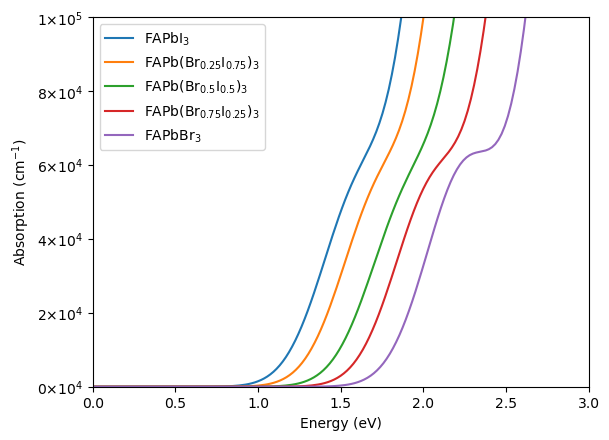

In [3]:
from scipy.ndimage import gaussian_filter1d

materials = {
    "FAPbI$_3$": {
        "dir" : 2.534, 
        "indir" :2.534, 
        "Br_frac": 0,
        "folder": "./HSE43/Br0I12/",
    },
    "FAPb(Br$_{0.25}$I$_{0.75}$)$_3$": {
        "dir": 2.638, 
        "indir": 2.638,
        "Br_frac": 0.25,
        "folder": "./HSE43/Br3I9/",
    },
    "FAPb(Br$_{0.5}$I$_{0.5}$)$_3$": {
        "dir": 2.746,
        "indir": 2.746,
        "Br_frac": 0.5,
        "folder": "./HSE43/Br6I6/",
    },
    "FAPb(Br$_{0.75}$I$_{0.25}$)$_3$": {
        "dir": 2.904,
        "indir": 2.904,
        "Br_frac": 0.75,
        "folder": "./HSE43/Br9I3/",
    },
    "FAPbBr$_3$": {
        "dir": 3.094,
        "indir": 3.094,
        "Br_frac": 1,
        "folder": "./HSE43/Br12I0/",
    },
}

#overrides = {"figure.figsize": [5, 4]}
#plt.style.use(["style.mplstyle", overrides])
fig, ax = plt.subplots()

for material, material_data in materials.items():
    data = np.loadtxt(material_data["folder"] + 'absorption.dat', delimiter=' ')
    energy = data[:,0]
    alpha_cm = data[:,1]
    
    efootlen = energy[1] - energy[0] #foot length of energy
    ediff_soc = - (mean_ediff_I * (1 - material_data["Br_frac"]) + mean_ediff_Br * material_data["Br_frac"])
    shiftnum = round(ediff_soc / efootlen)
    alpha_cm = alpha_cm[shiftnum:]
    energy = energy[:-shiftnum]
    ax.plot(energy, alpha_cm, label=material)

ax.set(xlim=[0,3],ylim = [0,1e5], xlabel='Energy (eV)', ylabel='Absorption (cm$^{-1}$)')
plt.legend()

# Custom formatter function to display labels as multiples of 10^4
def custom_formatter(x, pos):
    if x == 100000:
        return '1×10$^{5}$'  # Specific format for 100,000
    return f'{int(x/10000)}×10$^{4}$'

ax.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))

# corrected SLME

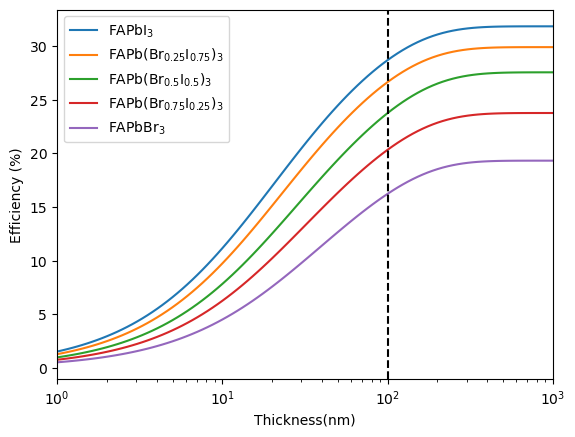

In [6]:
import pymatgen.analysis.solar.slme as slme

thickness = np.logspace(-9, -6, 100, endpoint=True)
thickness_nm = thickness*1000000000

#overrides = {"figure.figsize": [6, 4]}
#plt.style.use(["style.mplstyle", overrides])

for material, material_data in materials.items():
    data = np.loadtxt(material_data["folder"] + 'absorption.dat', delimiter=' ')
    energy = data[:,0]
    alpha_cm = data[:,1]
    
    efootlen = energy[1] - energy[0] #foot length of energy
    ediff_soc = - (mean_ediff_I * (1 - material_data["Br_frac"]) + mean_ediff_Br * material_data["Br_frac"])
    shiftnum = round(ediff_soc / efootlen)
    alpha_cm = alpha_cm[shiftnum:]
    energy = energy[:-shiftnum]
    effSlm = []
    bandgap = material_data["dir"] - ediff_soc
    for i in thickness:
        eff = data = slme.slme(energy,alpha_cm,bandgap, bandgap,thickness=i,absorbance_in_inverse_centimeters=True)
        effSlm.append(eff)
    plt.plot(thickness_nm, effSlm, label = material)

plt.axvline(x=100, linestyle='--', color = 'black')
plt.xscale('log')
plt.margins(x=0)
plt.xlabel("Thickness(nm)")
plt.ylabel("Efficiency (%)")
plt.legend()